# Experiment:Matrix Quadratic, Ill-conditioned

## Setup: импорты, путь к LIB, device/dtype, seed

In [1]:
import os, sys
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from types import SimpleNamespace

REPO = "/root/work/LIB"
sys.path.insert(0, REPO)
sys.path.insert(0, os.path.join(REPO, "src/"))

from optimizers.main import get_optimizer

torch.manual_seed(42)
np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32
print(device, dtype)

/root/.pyenv/versions/3.11.9/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


cuda torch.float32


## Генерация SPD матриц A,B с заданной κ (diagonal vs rotated)

In [8]:
def hadamard(n, device):
    assert n & (n-1) == 0
    H = torch.tensor([[1.0]], device=device)
    while H.shape[0] < n:
        H = torch.cat([torch.cat([H, H], 1),
                       torch.cat([H,-H], 1)], 0)
    return H / math.sqrt(n)
    
def make_orthogonal(d, device, dtype):
    M = torch.randn(d, d, device=device, dtype=dtype)
    Q, _ = torch.linalg.qr(M)
    return Q

def make_spd(d, kappa, mode="rotated", device="cpu", dtype=torch.float32):
    # eigenvalues in [1/kappa, 1], so cond=kappa but ||A||2 = 1
    lam = torch.logspace(
        -math.log10(kappa), 0.0, d, device=device, dtype=dtype
    )
    lam = lam / lam.mean()

    if mode == "diagonal":
        return torch.diag(lam)

    if mode == "rotated":
        Q = make_orthogonal(d, device, dtype)
    elif mode == "hadamard":
        Q = hadamard(d, device)
    else:
        raise ValueError(mode)

    return Q @ torch.diag(lam) @ Q.T


def cond_number_spd(A):
    # для SPD: κ = Lambda_max/lambda_min
    evals = torch.linalg.eigvalsh(A)
    return (evals.max() / evals.min()).item()

## Постановка задачи и “модель” с единственным параметром W

In [9]:
class MatrixParam(nn.Module):
    def __init__(self, m, n, device, dtype):
        super().__init__()
        W0 = torch.randn(m, n, device=device, dtype=dtype) * 0.1
        self.W = nn.Parameter(W0)

def loss_and_grad(W, W_star, A, B):
    # grad = A (W-W*) B
    E = W - W_star
    G = A @ E @ B
    # loss = 0.5 * Tr(E^T A E B)
    # стабильная реализация через sum(E * (A E B)):
    loss = 0.5 * torch.sum(E * G)
    return loss, G

## Функция запуска оптимизатора

In [10]:
def run_optimizer(opt_name, lr, A, B, W_star, steps=2000,
                  momentum=0.9, betas=(0.9, 0.999), eps=1e-8, ns_steps=10,
                  weight_decay=0.0, device="cpu", dtype=torch.float32):
    
    model = MatrixParam(A.shape[0], B.shape[0], device, dtype).to(device)
    
    # args под get_optimizer из LIB
    args = SimpleNamespace(
        optimizer=opt_name,
        lr=lr,
        momentum=momentum,
        beta1=betas[0],
        beta2=betas[1],
        eps=eps,
        weight_decay=weight_decay,
        ns_steps=ns_steps,
        update_freq=1,
        shampoo_beta=0.9,
        adamw_lr=lr,
    )
    opt = get_optimizer(args, model)

    losses = []
    grad_norms = []

    lr0 = lr
    for t in range(steps):
        lr_t = lr0 / math.sqrt(t + 1)
        for pg in opt.param_groups:
            pg["lr"] = lr_t
        W = model.W
        loss, G = loss_and_grad(W, W_star, A, B)

        # вручную выставляем градиент
        if W.grad is None:
            W.grad = torch.zeros_like(W)
        W.grad.copy_(G)

        opt.step()
        opt.zero_grad(set_to_none=True)

        if (t % 10) == 0:
            losses.append(loss.detach().cpu().item())
            grad_norms.append(G.detach().norm().cpu().item())

    return np.array(losses), np.array(grad_norms)

## Sweep по κ и режимам (diagonal vs rotated)

In [12]:
m = n = 128
kappas = [1e2, 1e4, 1e6]
modes = ["diagonal", "rotated"]

# W_target
W_star = torch.randn(m, n, device=device, dtype=dtype) * 0.5

optimizers = [
    ("sgd",    1e-3),
    ("adamw",  1e-2),
    ("muon",   2e-2),
    ("muadam", 5e-2),          # TAIA+adam (в LIB это muadam)
    ("muadam_sania", 1e-1),    # TAIA+adam_sania (в LIB muadam_sania)
]

results = []

for mode in modes:
    for kappa in kappas:
        A = make_spd(m, kappa, mode=mode, device=device, dtype=dtype)
        B = make_spd(n, kappa, mode=mode, device=device, dtype=dtype)

        print(f"\nmode={mode}, kappa={kappa:g}, cond(A)~{cond_number_spd(A):.2e}, cond(B)~{cond_number_spd(B):.2e}")
        
        # sanity checks
        offdiag = (A - torch.diag(torch.diag(A))).abs().mean().item()
        diag = torch.diag(A).abs().mean().item()
        print("offdiag/diag:", offdiag/diag)

        for opt_name, lr in optimizers:
            losses, grad_norms = run_optimizer(
                opt_name=opt_name, lr=lr, A=A, B=B, W_star=W_star,
                steps=2000, momentum=0.9, ns_steps=10, eps=1e-8,
                device=device, dtype=dtype
            )
            results.append({
                "mode": mode,
                "kappa": kappa,
                "optimizer": opt_name,
                "lr": lr,
                "losses": losses,
            })
            print(opt_name, "final loss:", losses[-1])


mode=diagonal, kappa=100, cond(A)~1.00e+02, cond(B)~1.00e+02
offdiag/diag: 0.0
sgd final loss: 207.76145935058594
adamw final loss: 110.61235046386719
muon final loss: 1096.3529052734375
muadam final loss: 731.594970703125
muadam_sania final loss: 273.41522216796875

mode=diagonal, kappa=10000, cond(A)~1.00e+04, cond(B)~1.00e+04
offdiag/diag: 0.0
sgd final loss: 79.64617156982422
adamw final loss: 113.14722442626953
muon final loss: 989.0646362304688
muadam final loss: 1146.1759033203125
muadam_sania final loss: 646.8505859375

mode=diagonal, kappa=1e+06, cond(A)~1.00e+06, cond(B)~1.00e+06
offdiag/diag: 0.0
sgd final loss: 41.951026916503906
adamw final loss: 121.50626373291016
muon final loss: 871.1481323242188
muadam final loss: 1275.16259765625
muadam_sania final loss: 882.1519775390625

mode=rotated, kappa=100, cond(A)~1.00e+02, cond(B)~1.00e+02
offdiag/diag: 0.08118259906768799
sgd final loss: 209.9508514404297
adamw final loss: 56.60253143310547
muon final loss: 1087.12622070312

## Графики log(loss) vs iteration

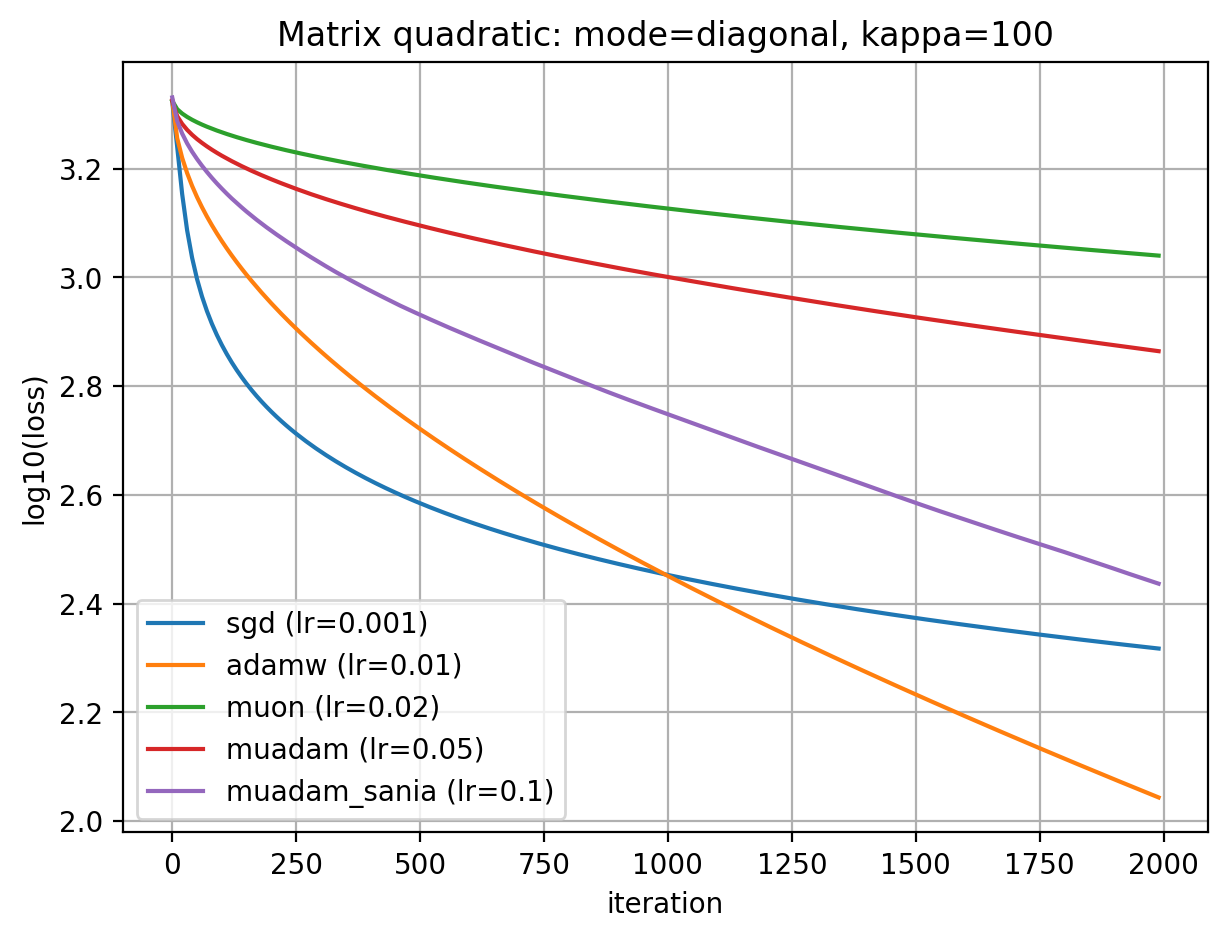

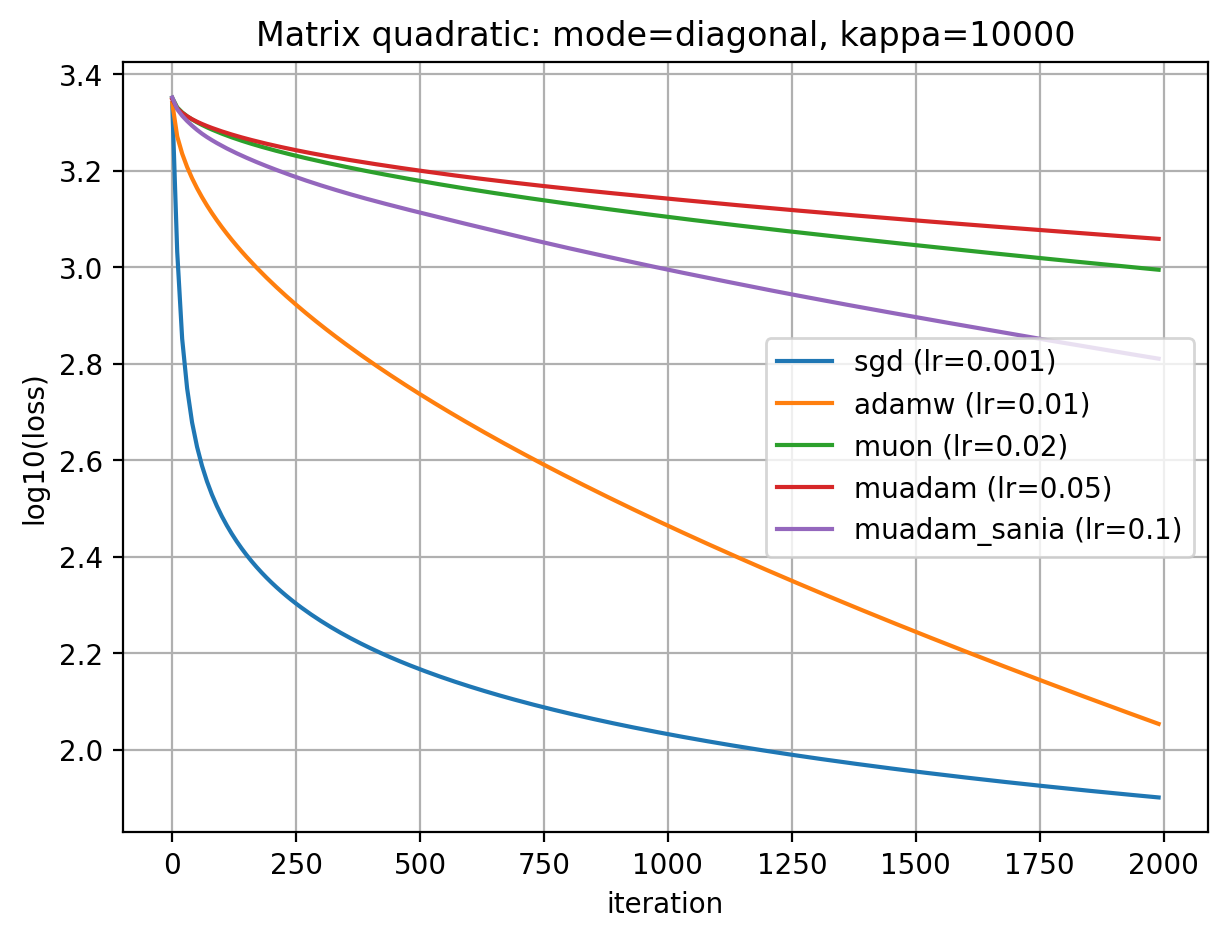

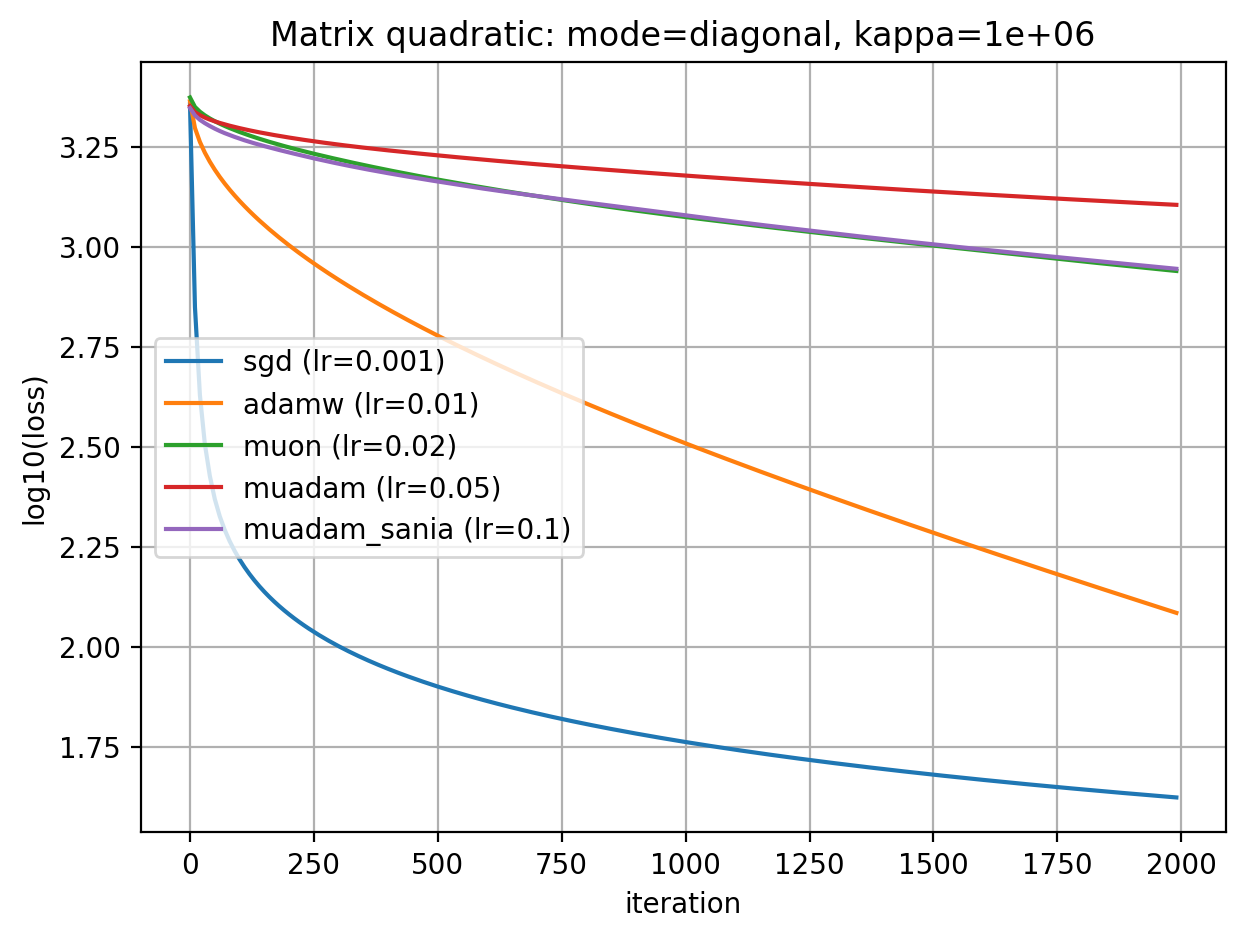

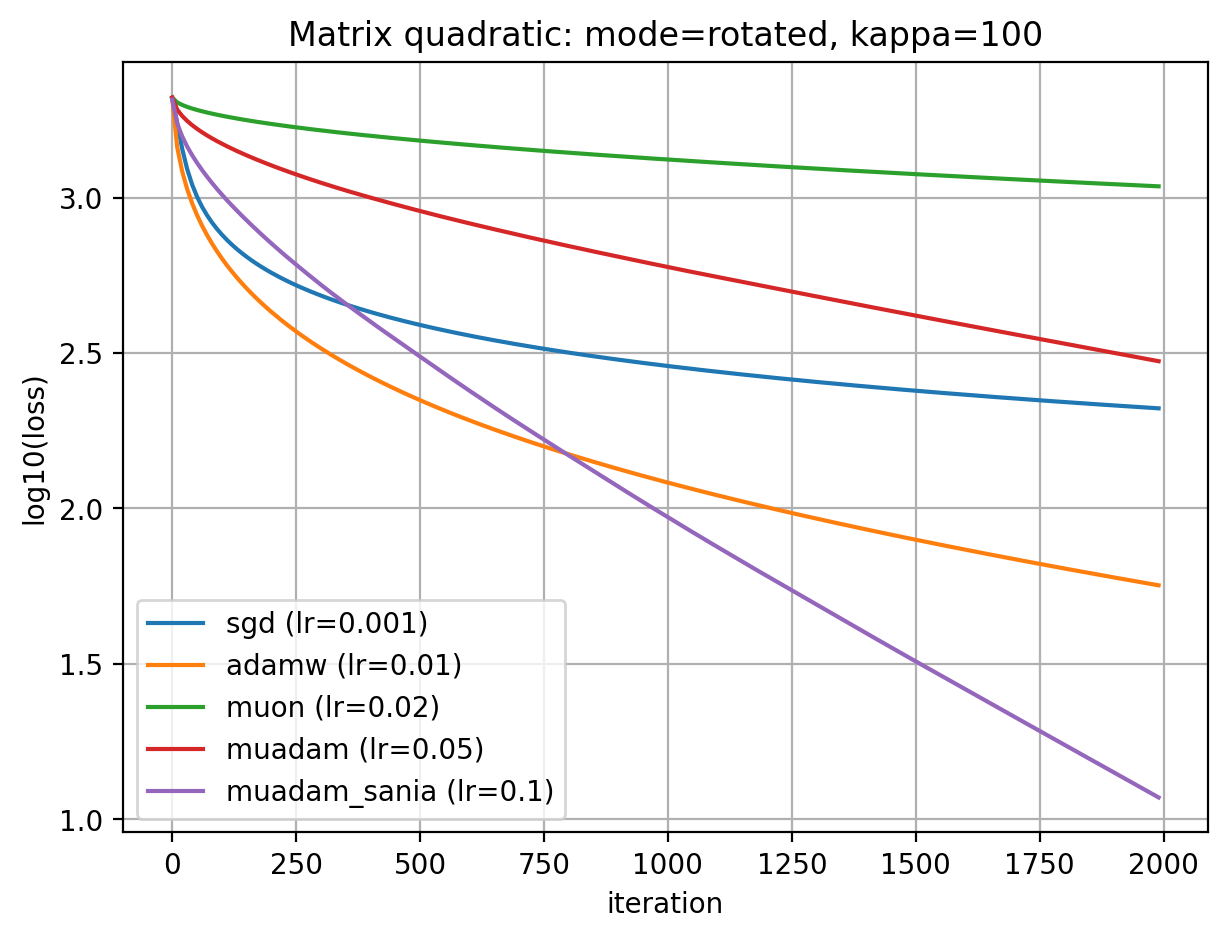

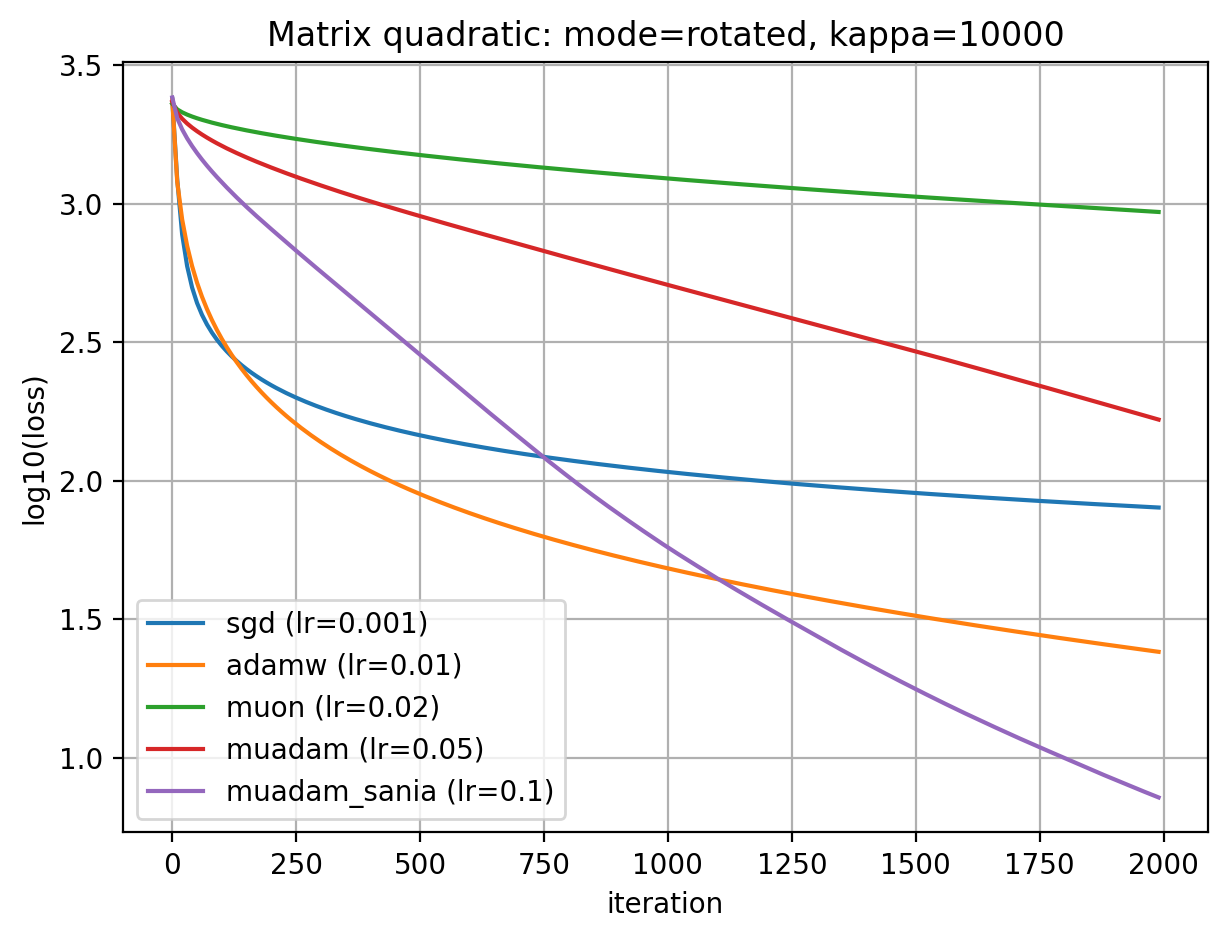

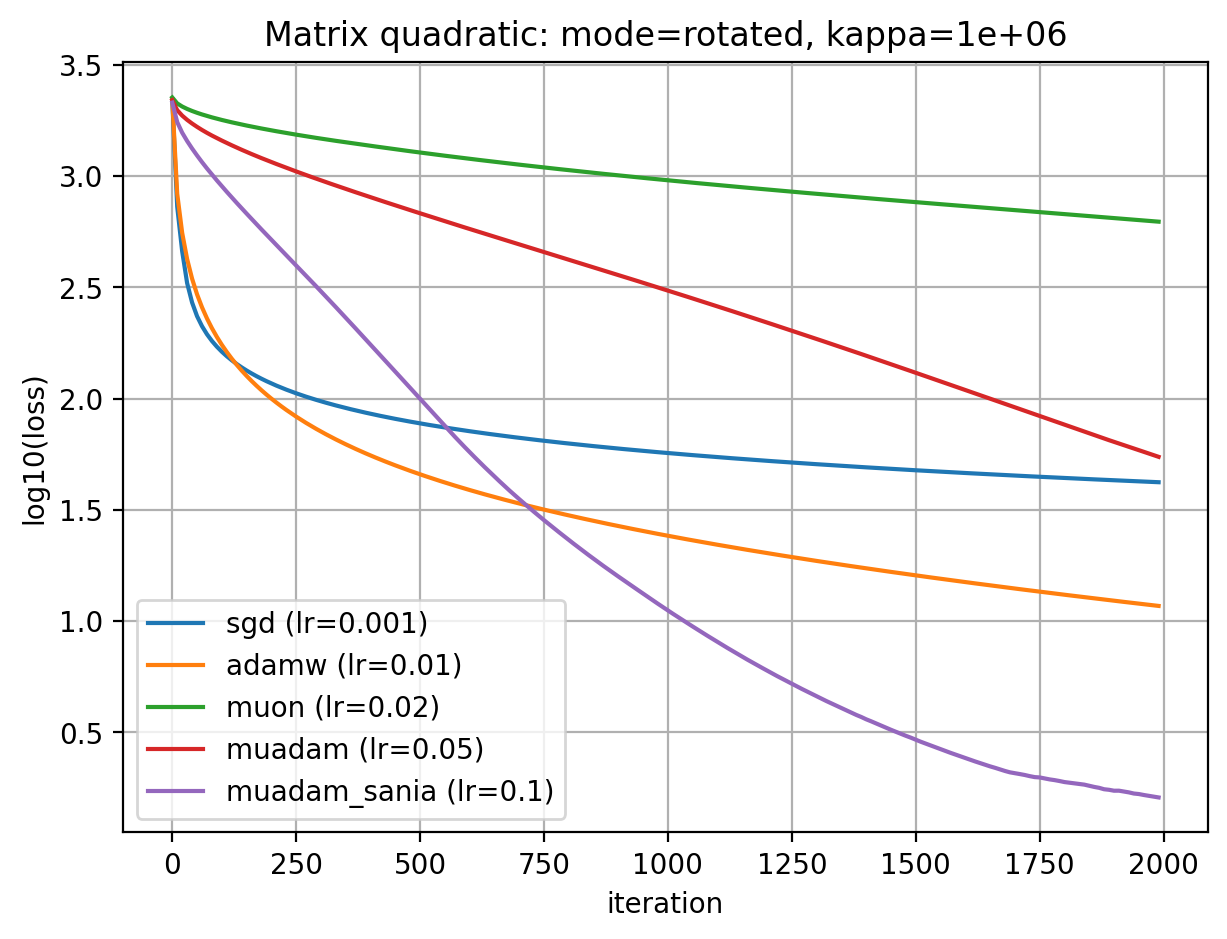

In [13]:
def plot_curves(results, mode, kappa):
    plt.figure(figsize=(7,5), dpi=200)
    for r in results:
        if r["mode"] == mode and r["kappa"] == kappa:
            y = np.maximum(r["losses"], 1e-30)
            x = np.arange(len(y)) * 10  # потому что логируем каждые 10 шагов
            plt.plot(x, np.log10(y), label=f'{r["optimizer"]} (lr={r["lr"]})')
    plt.xlabel("iteration")
    plt.ylabel("log10(loss)")
    plt.title(f"Matrix quadratic: mode={mode}, kappa={kappa:g}")
    plt.legend()
    plt.grid(True)
    plt.show()

for mode in modes:
    for kappa in kappas:
        plot_curves(results, mode, kappa)

In [16]:
m = n = 128
kappas = [1e2, 1e4, 1e6]
modes = ["hadamard"]

# W_target
W_star = torch.randn(m, n, device=device, dtype=dtype) * 0.5

optimizers = [
    ("sgd",    1e-3),
    ("adamw",  1e-2),
    ("muon",   2e-2),
    ("muadam", 5e-2),          # TAIA+adam (в LIB это muadam)
    ("muadam_sania", 1e-1),    # TAIA+adam_sania (в LIB muadam_sania)
]

results = []

for mode in modes:
    for kappa in kappas:
        A = make_spd(m, kappa, mode=mode, device=device, dtype=dtype)
        B = make_spd(n, kappa, mode=mode, device=device, dtype=dtype)

        print(f"\nmode={mode}, kappa={kappa:g}, cond(A)~{cond_number_spd(A):.2e}, cond(B)~{cond_number_spd(B):.2e}")
        
        # sanity checks
        offdiag = (A - torch.diag(torch.diag(A))).abs().mean().item()
        diag = torch.diag(A).abs().mean().item()
        print("offdiag/diag:", offdiag/diag)

        for opt_name, lr in optimizers:
            losses, grad_norms = run_optimizer(
                opt_name=opt_name, lr=lr, A=A, B=B, W_star=W_star,
                steps=2000, momentum=0.9, ns_steps=10, eps=1e-8,
                device=device, dtype=dtype
            )
            results.append({
                "mode": mode,
                "kappa": kappa,
                "optimizer": opt_name,
                "lr": lr,
                "losses": losses,
            })
            print(opt_name, "final loss:", losses[-1])


mode=hadamard, kappa=100, cond(A)~1.00e+02, cond(B)~1.00e+02
offdiag/diag: 0.02814589999616146
sgd final loss: 206.38755798339844
adamw final loss: 53.635047912597656
muon final loss: 1062.833740234375
muadam final loss: 493.1764831542969
muadam_sania final loss: 45.253501892089844

mode=hadamard, kappa=10000, cond(A)~1.00e+04, cond(B)~1.00e+04
offdiag/diag: 0.0621490553021431
sgd final loss: 77.60009765625
adamw final loss: 23.18170166015625
muon final loss: 820.642333984375
muadam final loss: 375.827392578125
muadam_sania final loss: 35.50559997558594

mode=hadamard, kappa=1e+06, cond(A)~1.01e+06, cond(B)~1.01e+06
offdiag/diag: 0.0952630490064621
sgd final loss: 39.311683654785156
adamw final loss: 12.254875183105469
muon final loss: 699.800537109375
muadam final loss: 372.91815185546875
muadam_sania final loss: 67.95407104492188


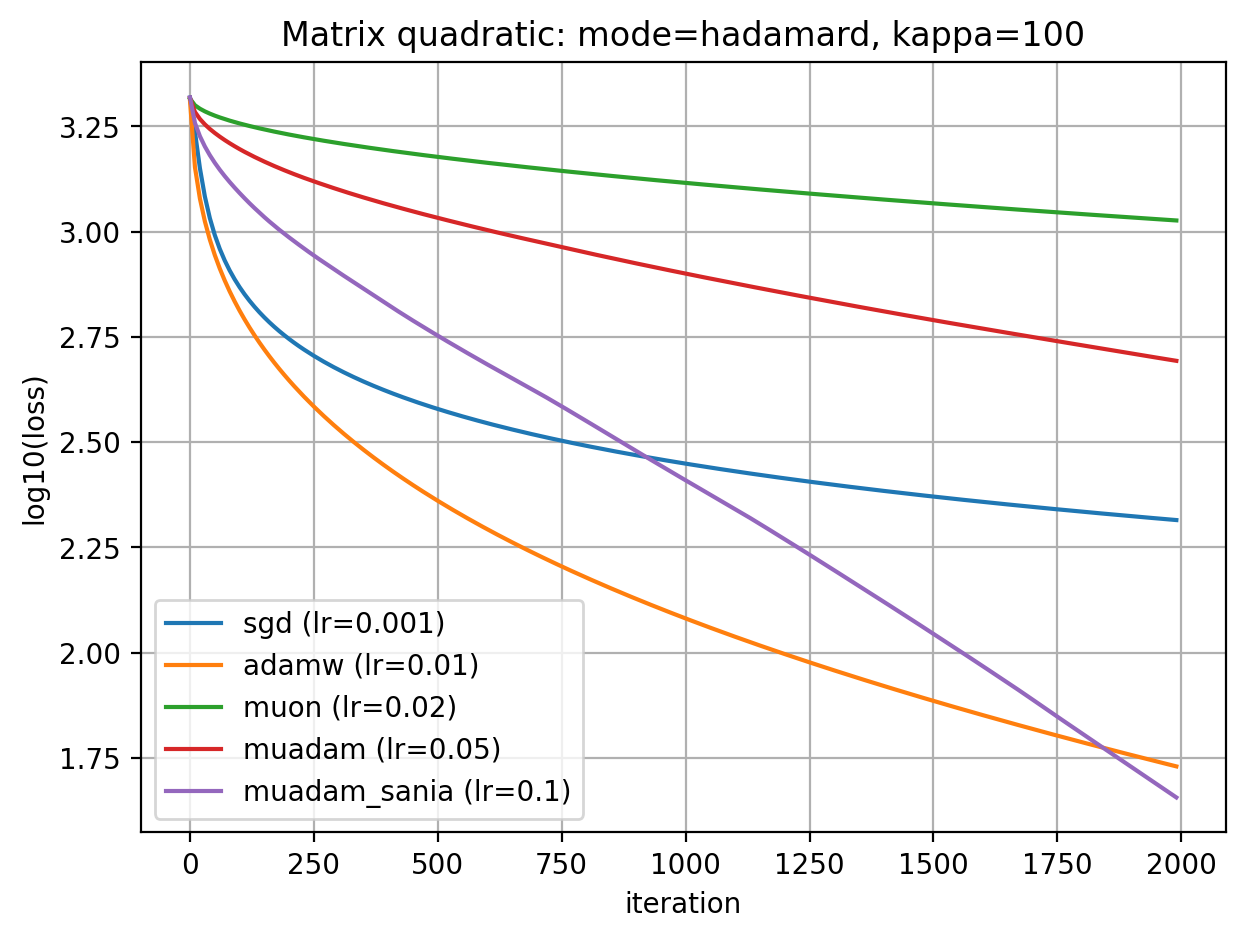

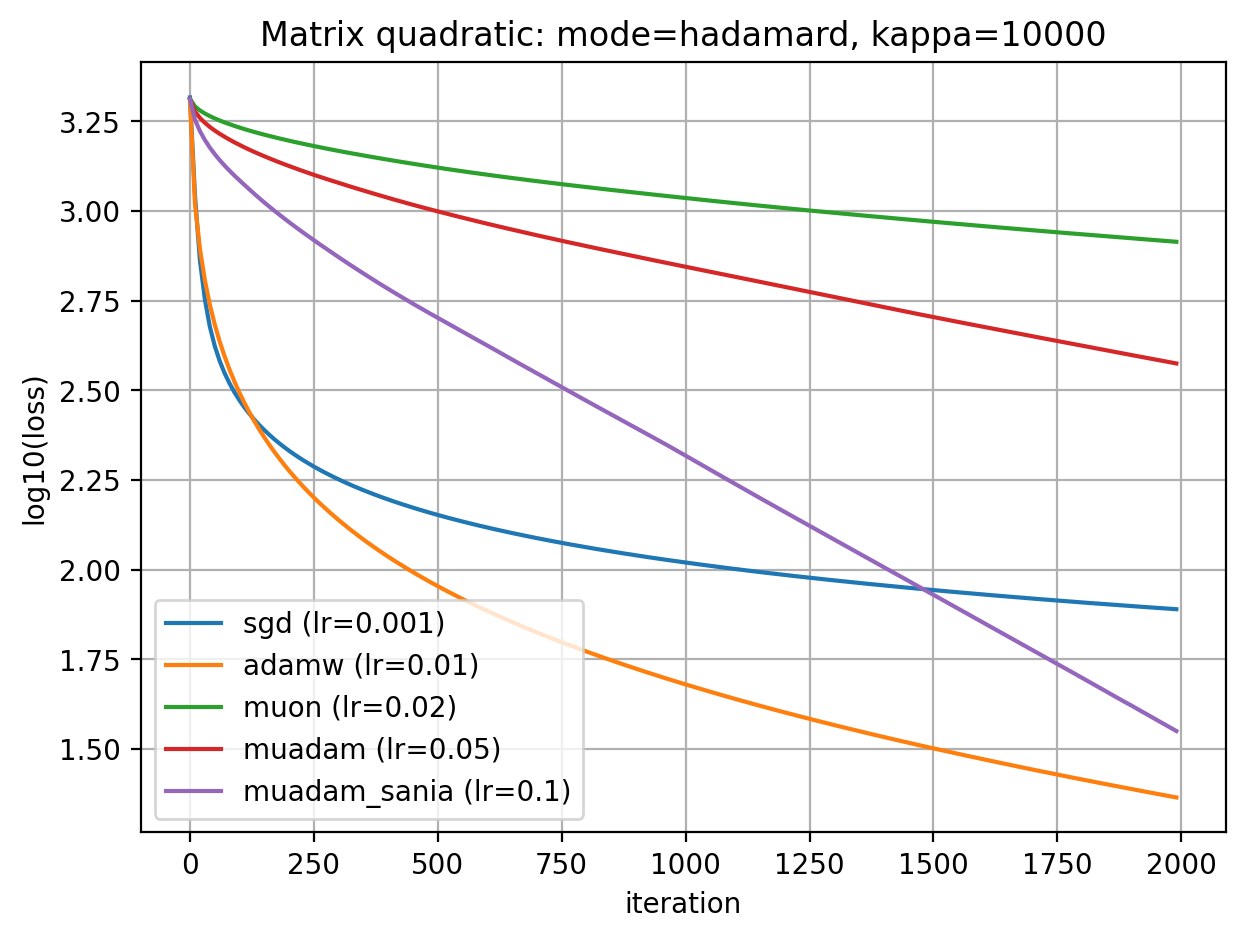

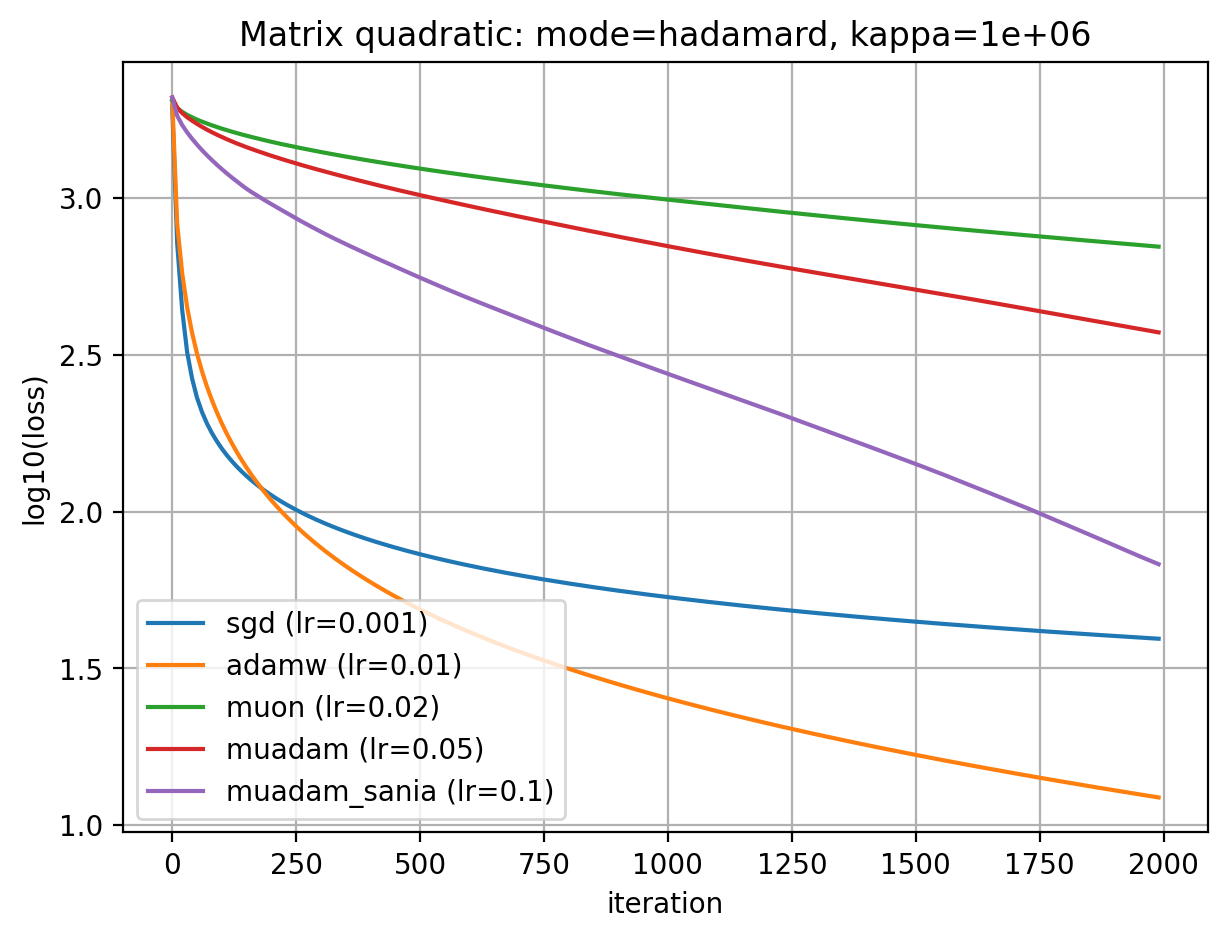

In [17]:
def plot_curves(results, mode, kappa):
    plt.figure(figsize=(7,5), dpi=200)
    for r in results:
        if r["mode"] == mode and r["kappa"] == kappa:
            y = np.maximum(r["losses"], 1e-30)
            x = np.arange(len(y)) * 10  # потому что логируем каждые 10 шагов
            plt.plot(x, np.log10(y), label=f'{r["optimizer"]} (lr={r["lr"]})')
    plt.xlabel("iteration")
    plt.ylabel("log10(loss)")
    plt.title(f"Matrix quadratic: mode={mode}, kappa={kappa:g}")
    plt.legend()
    plt.grid(True)
    plt.show()

for mode in modes:
    for kappa in kappas:
        plot_curves(results, mode, kappa)


### Diagonal

* Кривизна полностью описывается диагональю, внедиагональные элементы отсутствуют.
* AdamW показывает наилучший результат, так как его диагональный прекондиционер адекватно аппроксимирует обратную кривизну.
* Muon / MuAdam / MuAdam-SANIA не используют структурное преимущество диагональности и потому уступают по качеству.



### Rotated

* Диагональная структура изменена ортогональным поворотом, появляются значимые внедиагональные корреляции.
* Качество AdamW заметно ухудшается с ростом обусловленности (\kappa).
* MuAdam-SANIA демонстрирует существенно лучшую устойчивость, подтверждая пользу спектрального прекондиционирования в недиагональной геометрии.



### Hadamard

* Диагональные элементы кривизны практически выровнены, диагональная информация становится неинформативной.
* AdamW и другие диагональные методы теряют эффективность.
* MuAdam-SANIA стабильно превосходит остальные оптимизаторы, особенно при большой (\kappa), что указывает на его способность учитывать глобальную спектральную структуру задачи.

